<a href="https://colab.research.google.com/github/iitmcvg/Content/blob/master/HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction To Object Detection using HOG (Histogram of Oriented Gradients) in Python

Introduction to Object Detection [slides](https://www.canva.com/design/DAFPGGq_tEg/t9kFVU3HDlOiQYaqKnpfPQ/edit)



---



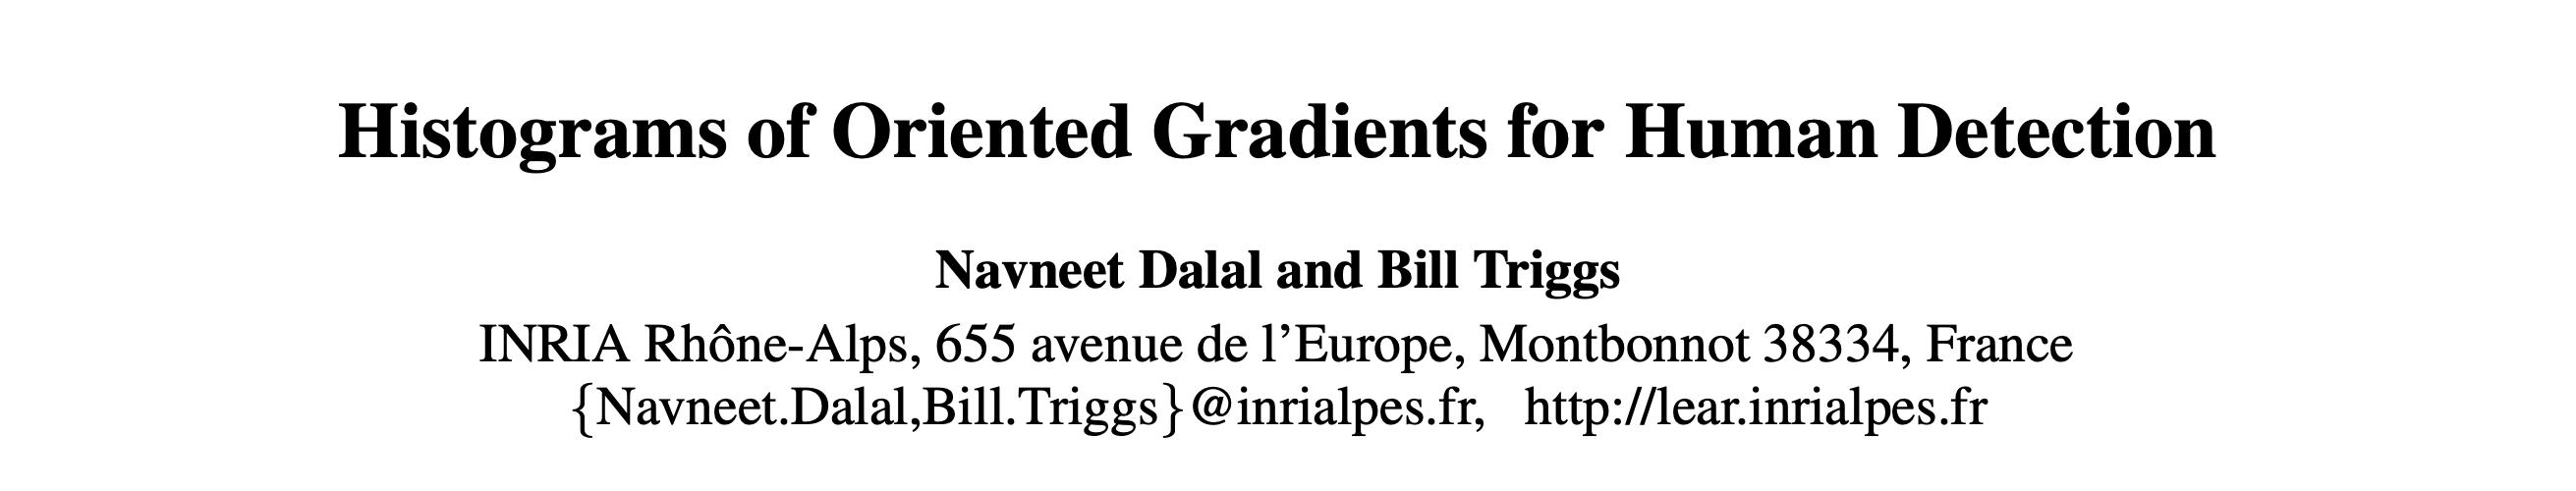

A Snippet of the orignal paper published in 2004 by Dalal and Briggs. 



[Link To The Paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi796mVyef6AhVqSGwGHYhyBOsQFnoECBMQAQ&url=https%3A%2F%2Flear.inrialpes.fr%2Fpeople%2Ftriggs%2Fpubs%2FDalal-cvpr05.pdf&usg=AOvVaw1ZGdJhqo9zT8KdtMuLdZ-L)



---



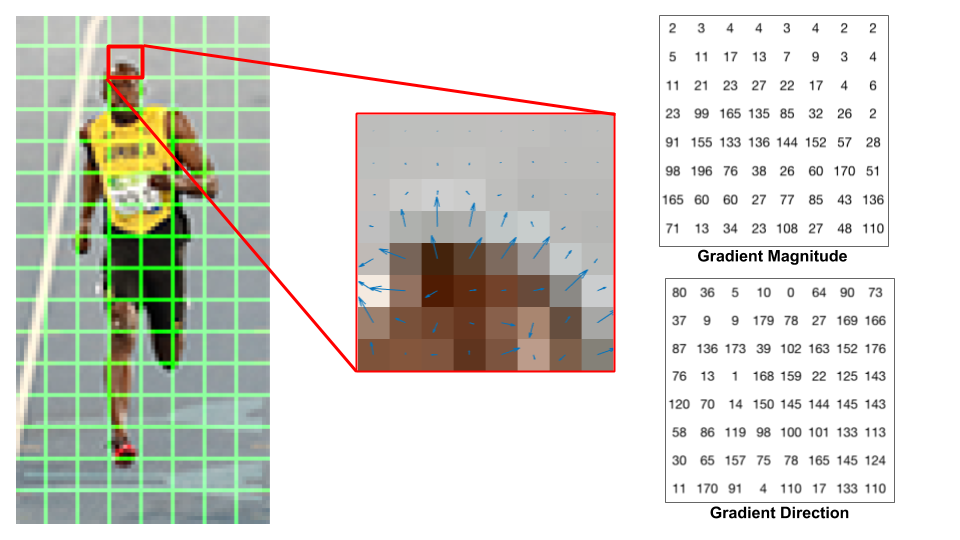

A visual representation of what HOG does. 
You should be able to make complete sense of what this does at the end of this presentation. 

---

#So what is HOG and what does it do?

HOG, as said previously, stands for Histogram of Oriented Gradients. 

---

**Histogram** : A histogram is a bar graph-like representation of data that buckets (bins) a range of classes

**Oriented** : Each element of the histogram will be representating the "Weight" of a particular orientation

**Gradients** : Rate of change of something (Pixel values in this case)

---

HOG tries to provide information about how the pixels change in the X and the Y direction, and the angle at which the resultant change lies. This orientation of gradients might seem pretty futile at first, but the key is that when combined with a histogram, it serves to be incredibly useful for finding patterns in images. 

#What does HOG Output?

The HOG algorithm will output what is known as a "Descriptor"; an array of elements which depict the weight of the gradient for a particular orientation. 

Note that HOG itself does not classify objects, but rather pre-procceses objects for better efficiency during the classification process using image classifiers like SVM (explained soon)

###**Importing libraries and required image**

In [ ]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog
import numpy as np
from skimage.io import imread, imshow
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

#How does HOG Work?

---
##Step 1: Resize The Image

Since HOG was initially developed for pedestrian detection, the algorithm was designed keeping in mind a 2:1 aspect ratio. So we will resize any image we have into a 64x128 sized image.

if we are to change the aspect ratio of the image, then the martrix size that we choose in later stages to combine gradient values also change. This means that we have a cascading effect of changes for a change in aspect ratio, or even resolution.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img = resize(color.rgb2gray(io.imread("/content/drive/MyDrive/B.jpg")), (128, 64))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  """Entry point for launching an IPython kernel.


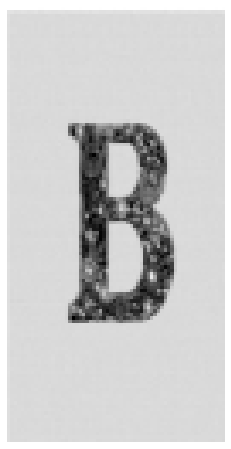

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

---
##Step 2 : Finding the gradients
Calculate the gradient for every pixel. Since we are calculating gradient in the X and Y direction, we find the differece between the pixels in 2 seperate orders. 

After we have gradients along X and Y direction, we will now have the angle from the X axis stored as well.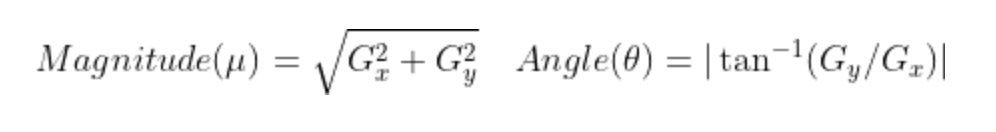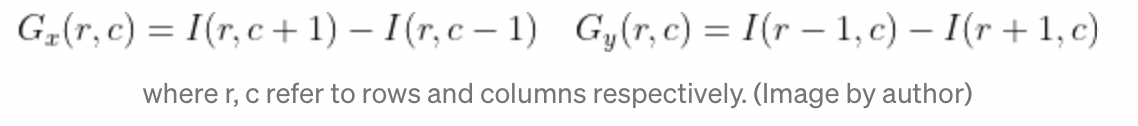

In [ ]:
mag = []
theta = []
for i in range(128):
  magnitudeArray = []
  angleArray = []
  for j in range(64):
    # Condition for axis 0
    if j-1 <= 0 or j+1 >= 64: 
      #This is essentially adding padding so that the edge pixels are also counted in the gradient
      if j-1 <= 0:
        # Condition if first element
        Gx = img[i][j+1] - 0
      elif j + 1 >= len(img[0]):
        Gx = 0 - img[i][j-1]
    # Condition for first element
    else:
      Gx = img[i][j+1] - img[i][j-1]
    
    # Condition for axis 1
    if i-1 <= 0 or i+1 >= 128:
      if i-1 <= 0:
        Gy = 0 - img[i+1][j]
      elif i +1 >= 128:
        Gy = img[i-1][j] - 0
    else:
      Gy = img[i-1][j] - img[i+1][j]

    # Calculating magnitude
    magnitude = math.sqrt(pow(Gx, 2) + pow(Gy, 2))
    magnitudeArray.append(round(magnitude, 9))

    # Calculating angle
    if Gx == 0:
      angle = math.degrees(0.0)
    else:
      angle = math.degrees(abs(math.atan(Gy / Gx)))
    angleArray.append(round(angle, 9))
  mag.append(magnitudeArray)
  theta.append(angleArray)

In [ ]:
img = np.array(img)

In [ ]:
mag = np.array(mag)

In [ ]:
theta = np.array(theta)

###**Visualization of magnitude of the image**

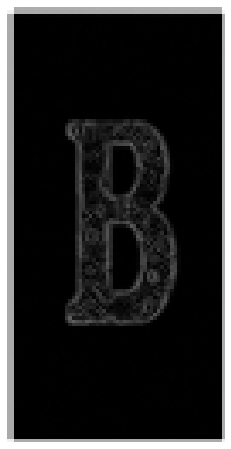

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(mag, cmap="gray")
plt.axis("off")
plt.show()

###**Visualization of angle of the image**

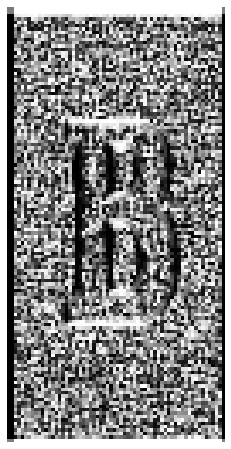

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(theta, cmap="gray")
plt.axis("off")
plt.show()

##Step 3: Binning The Gradients

Similar to pixel binning in smartphone camera systems, once we have the gradient info of every pixel, we group them in 8x8 matrices, and bin them into 9 seperate bins of 20 degrees each. 

That is, every pixel has a magnitude and direction value. So for a set of 64 pixels, we divide the magnitudes into 9 bins, so that we can get a general idea of what's happening in that block of pixels, and where the gradient is moving in general, rather than granular. 

Also note that the gradient values are unsigned, hence why we have 9 bins of amounting to 180 degrees and not 18 bins amounting to 360 degrees. 

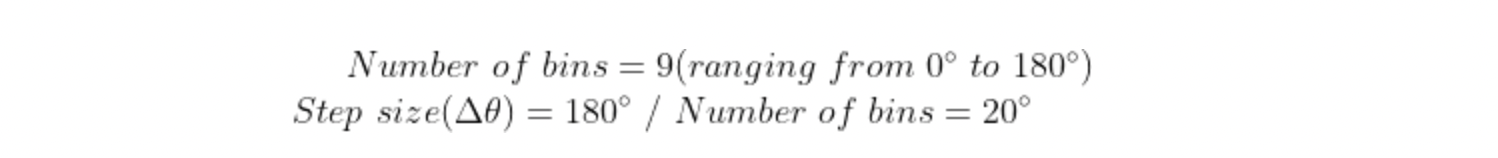

---

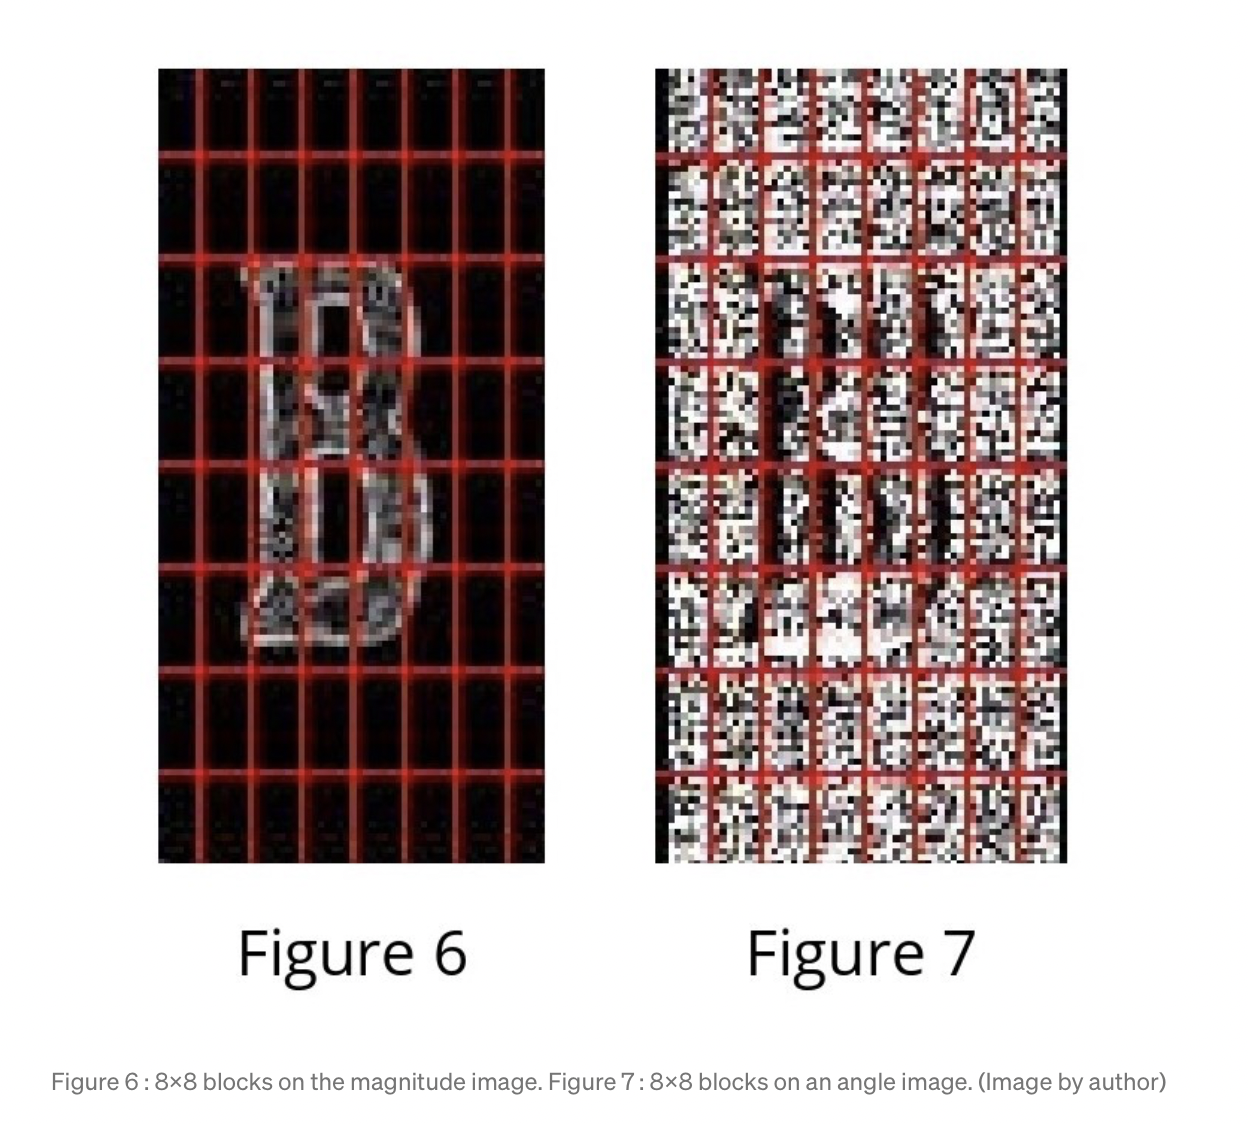

A visual representation of the blocks that are taken to bin the values

---

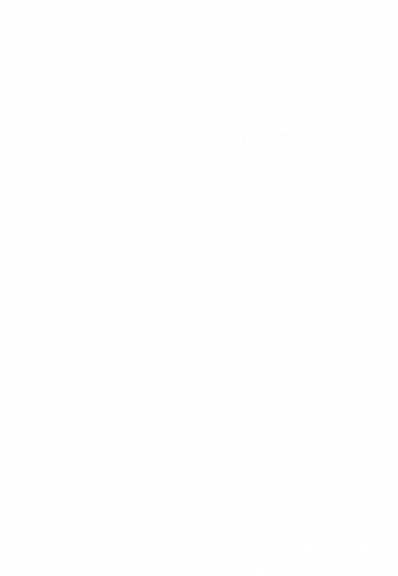

Another animation of the 8x8 blocks overlapping over each other

---


In [ ]:
number_of_bins = 9
step_size = 180 / number_of_bins

Another key is understanding how the magnitude is dristributed within the bins. Since the angles are not always multiples of 20 degrees, we split the magnitudes in proportion to their proximity to the nearest multiple of 20. 

So if we have 30 degrees and a magnitude of 10. We will add 5 in the 20 degree bin and 5 in 40 degree bin. 

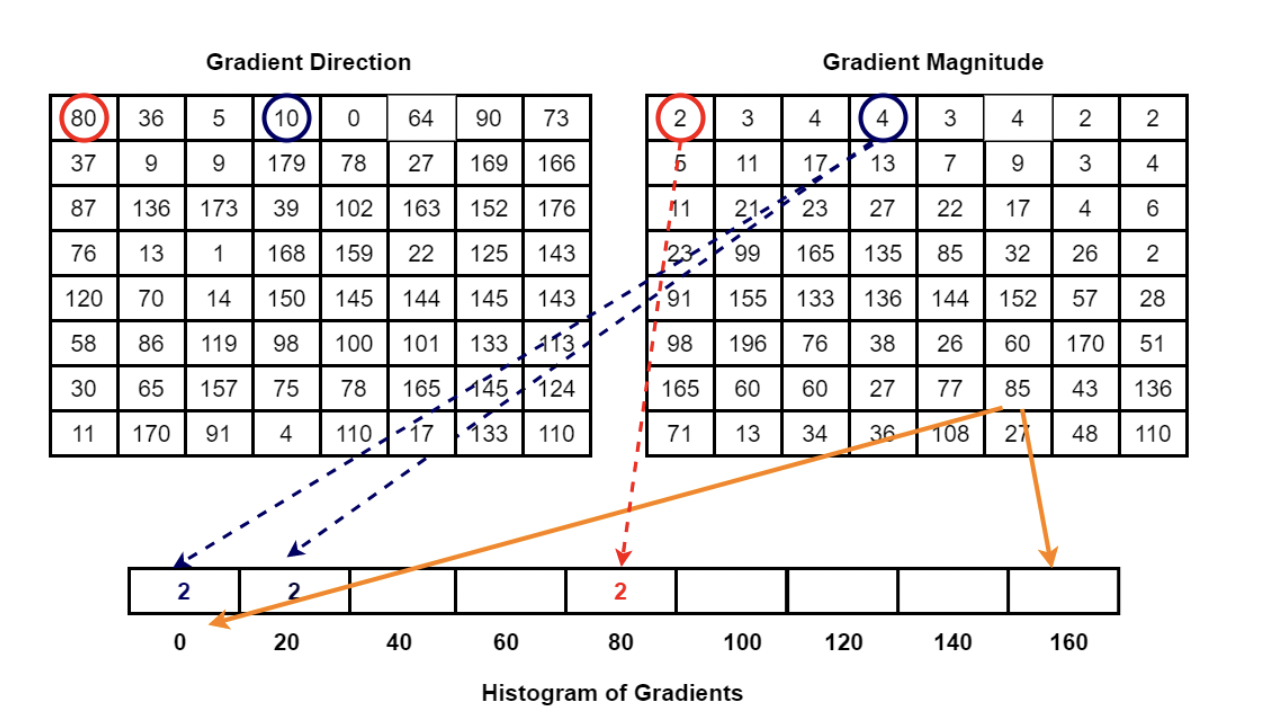

Another visualisation of the same method of binning

---

###**Function to calculate the $j^{th}$ bin**

In [ ]:
def calculate_j(angle):
  temp = (angle / step_size) - 0.5
  j = math.floor(temp)
  return j

###**Function to calculate the value of centre of $j^{th}$ bin**

In [ ]:
def calculate_Cj(j):
  Cj = step_size * (j + 0.5)
  return round(Cj, 9)

###**Function to calculate the value of $j^{th}$ bin**

In [ ]:
def calculate_value_j(magnitude, angle, j):
  Cj = calculate_Cj(j+1)
  Vj = magnitude * ((Cj - angle) / step_size)
  return round(Vj, 9)

###**Provides a 9 point histogram for 8x8 cells**

In [ ]:
histogram_points_nine = []
for i in range(0, 128, 8):
  temp = []
  for j in range(0, 64, 8):
    magnitude_values = [[mag[i][x] for x in range(j, j+8)] for i in range(i,i+8)]
    angle_values = [[theta[i][x] for x in range(j, j+8)] for i in range(i, i+8)]
    for k in range(len(magnitude_values)):
      for l in range(len(magnitude_values[0])):
        bins = [0.0 for _ in range(number_of_bins)]
        value_j = calculate_j(angle_values[k][l])
        Vj = calculate_value_j(magnitude_values[k][l], angle_values[k][l], value_j)
        Vj_1 = magnitude_values[k][l] - Vj
        bins[value_j]+=Vj
        bins[value_j+1]+=Vj_1
        bins = [round(x, 9) for x in bins]
    temp.append(bins)
  histogram_points_nine.append(temp)

In [ ]:
print(len(histogram_points_nine))
print(len(histogram_points_nine[0]))
print(len(histogram_points_nine[0][0]))

16
8
9


##Step 4: Grouping The Histograms

Now that we have condensed 64 pixel values into 9 values. We further group 4 such 8x8 matrices to form a 2x2 block, that is 16x16 cell, and append the 1x9 matrix column-wise to generate a 1x36 matrix. Untill now this move makes no sense, as anyway none of the data is being modified, just 4 1x9 matrices are being combined. 

However it will make sense when we proceed to Step 5: Normalisation

##Step 5: Normalisation

Now we **normalise** the histograms.

Why do we do this? Essentially, if every pixel value becomes double of what it was initially, the empirical gradient remains the same, however the gradient values themselves will become double. 

So 2 images, one just higher contrast than the other will yield different values, which is not good for the purpouse of object detection. So we will focus on normalising the values, which is just dividing the individual values by the net magnitude (kind of like finding unit vectors)

The reason we normalise 1x36 vectors rather than 1x9 vectors is because normalising over 36 values minimises noise further and gives us a better picture, while still retaining local detail. 

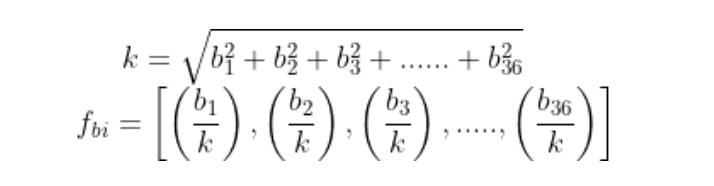

---


##Step 6: Combining feature vector histograms 

Finally we take the multiple feature vectors (36 of them per block) and concatenate all of them to create a feature vector matrix that has 3780 terms. 

How 3780? Well a 64x128 image can have 15 blocks along the vertical, and 7 along the horizontal. So we will have 36 x 15 x 7 = 3780 feature vectors. 

This final matrix is the "HOG Descriptor". We will pass this descriptor through the SVM : Support Vector Machine, and it will tell us what object it is based on it's information from the positive and negative descriptor. 

###**Provides a HOG feature vector for the 9 point histogram provided by making block from 2x2 blocks**

###**(1 block is made up of 8x8 cells)**

In [ ]:
epsilon = 1e-05

In [ ]:
feature_vectors = []
for i in range(0, len(histogram_points_nine) - 1, 1):
  temp = []
  for j in range(0, len(histogram_points_nine[0]) - 1, 1):
    values = [[histogram_points_nine[i][x] for x in range(j, j+2)] for i in range(i, i+2)]
    final_vector = []
    for k in values:
      for l in k:
        for m in l:
          final_vector.append(m)
    k = round(math.sqrt(sum([pow(x, 2) for x in final_vector])), 9)
    final_vector = [round(x/(k + epsilon), 9) for x in final_vector]
    temp.append(final_vector)
  feature_vectors.append(temp)

In [ ]:
print(len(feature_vectors))
print(len(feature_vectors[0]))
print(len(feature_vectors[0][0]))

15
7
36


###**Number of HOG features obtained**

In [ ]:
print(f'Number of HOG features = {len(feature_vectors) * len(feature_vectors[0]) * len(feature_vectors[0][0])}')

Number of HOG features = 3780


###We will now proceed to use this to supply this to an SVM which will detect what we are seeing. 

##Doing the same with OpenCV
OpenCV is a very powerful library, let's see a case in point right now!

(134, 70, 3)
(128, 64, 3)


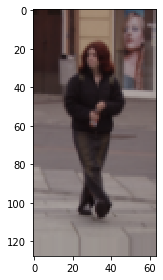

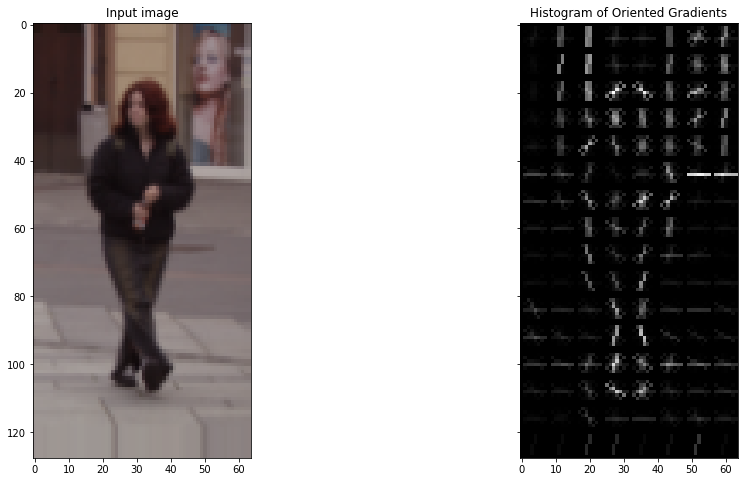

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline


#reading the image
img = imread('/content/drive/MyDrive/10.jpg')
imshow(img)
print(img.shape)

resized_img = resize(img, (128,64)) 
imshow(resized_img) 
print(resized_img.shape)

fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

fd.shape

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.savefig("output.png")

plt.show()

(128, 64)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.001249   ... 0.00474504 0.         0.        ]
 [0.         0.00157702 0.         ... 0.         0.01426953 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


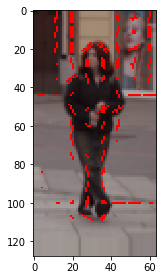

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline


#reading the image
img = imread('/content/drive/MyDrive/images/10.png')
imshow(img)

resized_img = resize(img, (128,64)) 


fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
print(hog_image.shape)

#print(hog_image.shape)

gg= (np.array(resized_img))
#print(gg)
print(hog_image)

for i in range(128):
  for j in range(64):
    if (hog_image[i][j]) < 0.045:
      continue
    else:
      gg[i][j]=[255,0,0]

from matplotlib import pyplot as plt
plt.imshow(gg, interpolation='nearest')
plt.show()

In [ ]:
import numpy
 
# create an array
a = numpy.array(hog_image)
 
# save array into csv file
numpy.savetxt("data3.csv", a,
              delimiter = ",")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Quick recap of SVM**


The [**Support Vector Machine**](https://towardsdatascience.com/implementing-svm-from-scratch-784e4ad0bc6a) ***(SVM)***, developed by the computer science community in the 1990s, is a supervised learning algorithm commonly used and originally intended for a binary classification setting.

SVM uses maximum marginal classifier algorithm to find the hyperplane.But what is a hyperplane?

"Hyperplane" is the plane which classifies the datapoints with maximum margin between them.Margin is the sum of distance between the plane and two nearest datapoints of the two classes to the plane.


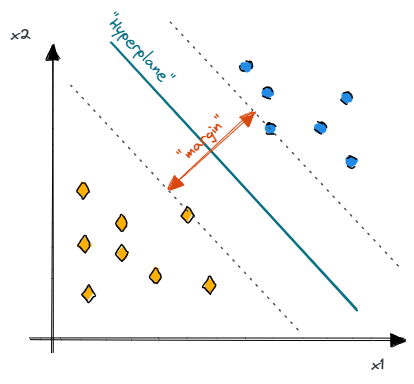
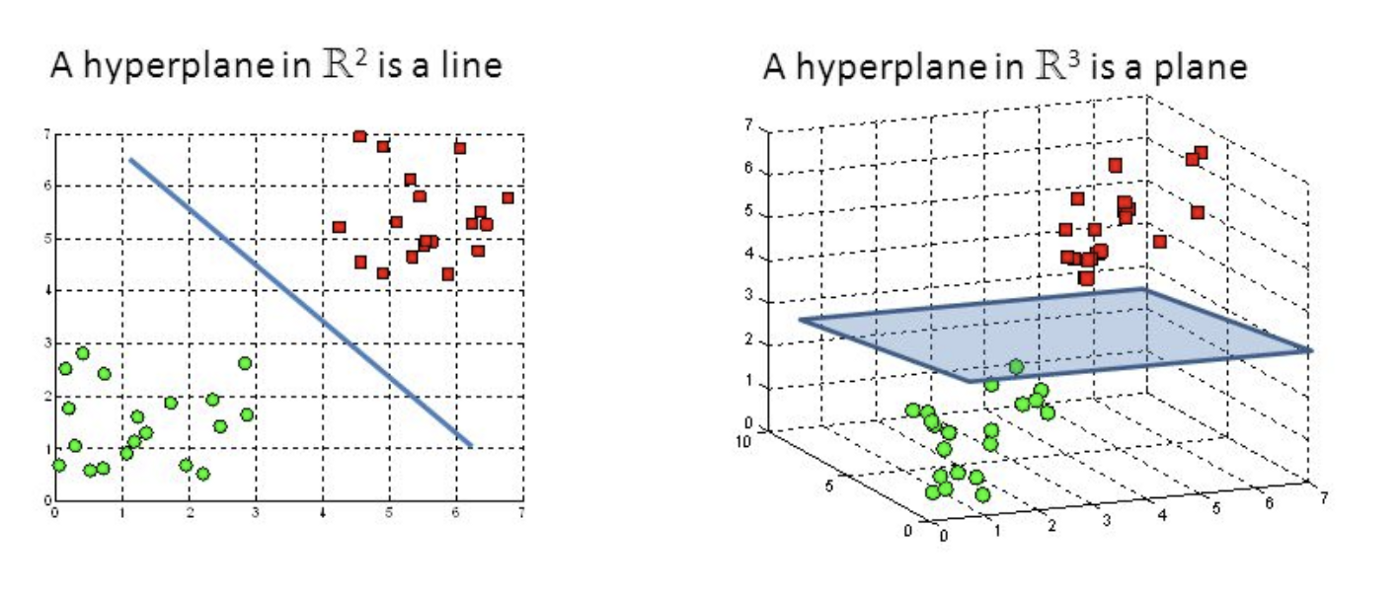

In general, a hyperplane in p dimensions can be described as a flat affine subspace with the dimension p-1.

For example dataset with two features(2D) can be classified by a hyperplane of dimension-1.First to get the hyperplane , we will classify the datapoints as $\{1,-1\}.$

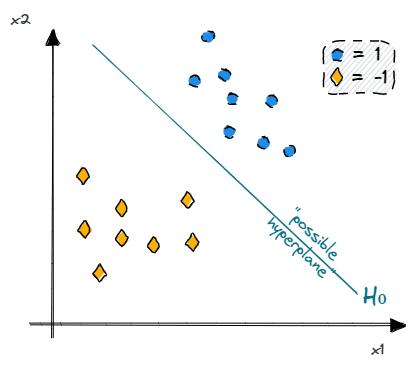

Generally we can write the equation of the plane as  image.png 

But two classes of data can seperated by multiple hyperplanes , but how we will choose the optimal hyperplane ? The answer is the hyperplane with maximum margin or distance between the two class of datapoints.

 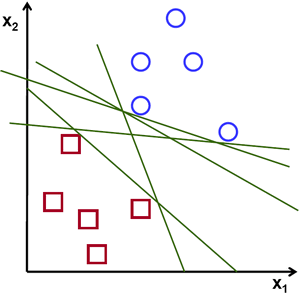                                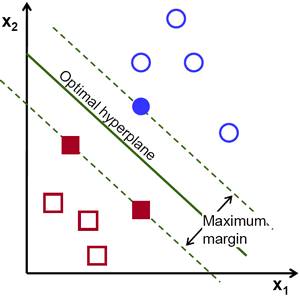

**How to sperate features if they are not linear?**
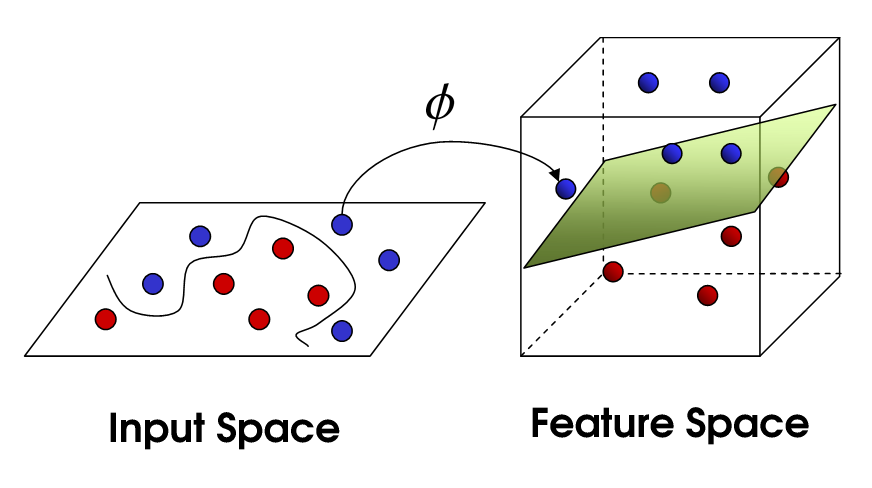
As you can see in the above picture, if we find a way to map the data from 2-dimensional space to 3-dimensional space, we will be able to find a decision surface that clearly divides between different classes. My first thought of this data transformation process is to map all the data point to a higher dimension (in this case, 3 dimension), find the boundary, and make the classification.
That sounds alright. However, when there are more and more dimensions, computations within that space become more and more expensive. This is when the kernel trick comes in. It allows us to operate in the original feature space without computing the coordinates of the data in a higher dimensional space.

Generally the kernel trick will help us to convert the datapoints in inputspace of lower dimension to a higher dimension , so that the datapoints become "linearly seperable" in the higher dimension space. There are different types of kernels available in SVM like "linear kernel","RBF",etc..Each kernel has it's own features and can be used in different situations.
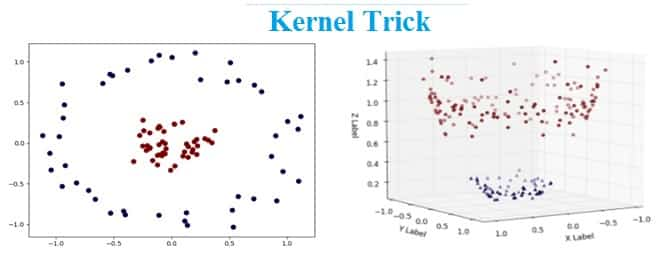

Here in the above image , we are seeing the "RBF" kernel , which seperates the datapoints based on the distance between the point and origin. 
Another example , Here we apply the transformation  𝜙(𝑥)=𝑥  mod 2
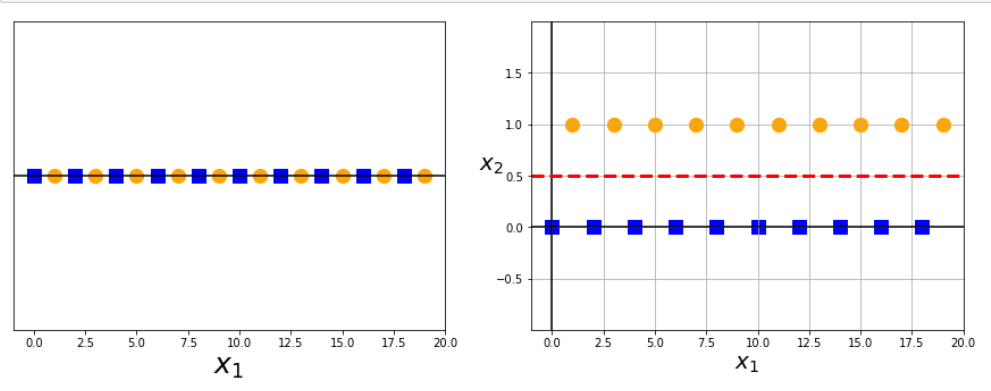

# **Different types of kernel**
**Gaussian Kernel**

It is used to perform transformation when there is no prior knowledge about data.

image.png

**Gaussian Kernel Radial Basis Function (RBF)**

Same as above kernel function, adding radial basis method to improve the transformation.


image.png


image.png


image.png


image.png


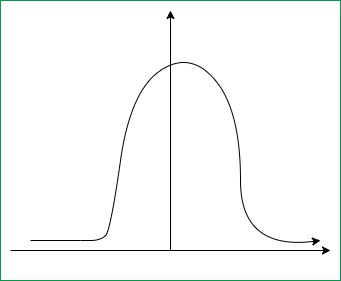


**Sigmoid Kernel**

This function is equivalent to a two-layer, perceptron model of the neural network, which is used as an activation function for artificial neurons.

image.png

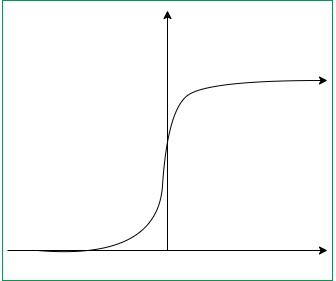



**Polynomial Kernel**

It represents the similarity of vectors in the training set of data in a feature space over polynomials of the original variables used in the kernel.

image.png

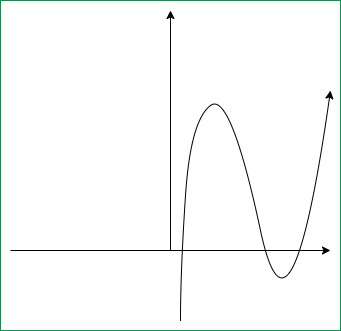



To get a finer-grained idea of how well a classifier is doing, we derive certain parameters. Before that we need to know what some of these terms mean.

Consider a test data of 91 patients tested for heart disease.

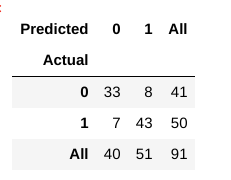


From our train and test data, we already know that our test data consisted of 91 data points. That is the 3rd row and 3rd column value at the end. We also notice that there are some actual and predicted values. The actual values are the number of data points that were originally categorized into 0 or 1. The predicted values are the number of data points our KNN model predicted as 0 or 1.

The actual values are:

The patients who actually don’t have a heart disease = 41
The patients who actually do have a heart disease = 50

The predicted values are:


Number of patients who were predicted as not having a heart disease = 40

Number of patients who were predicted as having a heart disease = 51

All the values we obtain above have a term. Let’s go over them one by one:

1)The cases in which the patients actually did not have heart disease and our model also predicted as not having it is called the True Negatives. For our matrix, **True Negatives** = 33.

2)The cases in which the patients actually have heart disease and our model also predicted as having it are called the True Positives. For our matrix, **True Positives** = 43

3)However, there are are some cases where the patient actually has no heart disease, but our model has predicted that they do. This kind of error is the Type I Error and we call the values as False Positives. For our matrix, **False Positives** = 8

4)Similarly, there are are some cases where the patient actually has heart disease, but our model has predicted that he/she don’t. This kind of error is the Type II Error and we call the values as False Negatives.  For our matrix, **False Negatives** = 7

# **Precision**
In the simplest terms, Precision is the ratio between the True Positives and all the Positives. For our problem statement, that would be the measure of patients that we correctly identify having a heart disease out of all the patients actually having it. 

Mathematically:

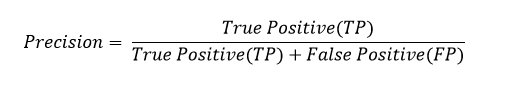

# **Recall**

The recall is the measure of our model correctly identifying True Positives. Thus, for all the patients who actually have heart disease, recall tells us how many we correctly identified as having a heart disease. 

Mathematically:

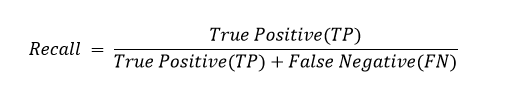

# **Accuracy**

Accuracy is the ratio of the total number of correct predictions and the total number of predictions

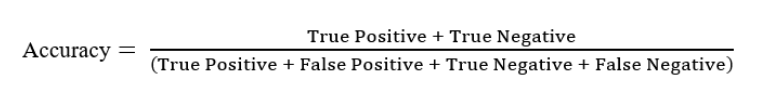

# **Training SVM classifier with HOG features**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/content"]).decode("utf8"))

data3.csv
drive
output.png
sample_data



In [ ]:
f = open(r'/content/drive/MyDrive/shipsnet.json')
dataset = json.load(f)
print(f)
f.close()

dataset.keys()

<_io.TextIOWrapper name='/content/drive/MyDrive/shipsnet.json' mode='r' encoding='UTF-8'>


dict_keys(['data', 'labels', 'locations', 'scene_ids'])

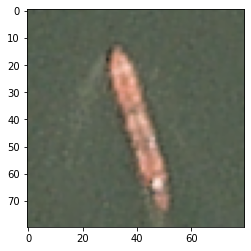

In [ ]:
data = np.array(dataset['data']).astype('uint8')
img_length = 80
data = data.reshape(-1,3,img_length,img_length).transpose([0,2,3,1])

plt.imshow(data[51])

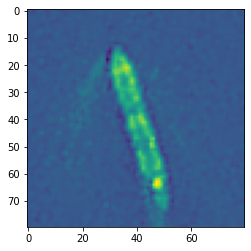

In [ ]:
data_gray = [ color.rgb2gray(i) for i in data]
plt.imshow(data_gray[51])

In [ ]:
ppc = 16
hog_images = []
hog_features = []
for image in data_gray:
    fd, hog_image= hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

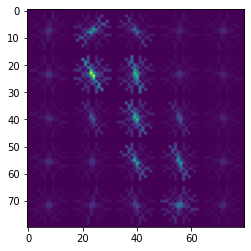

In [ ]:

plt.imshow(hog_images[1])

In [ ]:
labels =  np.array(dataset['labels']).reshape(len(dataset['labels']),1)

In [ ]:
clf = svm.SVC()
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,labels))
np.random.shuffle(data_frame)


In [ ]:
#What percentage of data you want to keep for training
percentage = 80
partition = int(len(hog_features)*percentage/100)


In [ ]:
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

clf.fit(x_train,y_train)


SVC()

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9910714285714286


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       427
         1.0       0.98      0.98      0.98       133

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560

